# QUIMB save boundary operators
Created 15/09/2025

Objectives:
* Implement [variational optimization of unitaries](https://quimb.readthedocs.io/en/latest/examples/ex_tn_train_circuit.html).
* Use ansatz from [this paper](https://link.aps.org/doi/10.1103/PhysRevA.101.062310).

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [12]:
DATA_DIR = r"../../../data/transverse_cluster_200_site_dmrg"

In [13]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [14]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [15]:
psi_dict = dict()

In [16]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [17]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [18]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [19]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [20]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

## Optimisation functions

In [21]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = c_abs_squared.astype('float32')

    1-c_abs_squared

    return loss

## Gate functions

In [24]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [25]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

In [54]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.uni
    
    if first_site != 0:
        index_labels = ['k', 'b']

        index_map = {
            f'{l}{i}': f'{l}{i+first_site}'
            for i in range(n)
            for l in index_labels
        }

        circ.reindex(index_map, inplace=True)

    return circ

In [60]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        **kwargs
    )

    right_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        **kwargs
    )

    circ_pair = (left_circuit & right_circuit)

    return circ_pair

# Initizialize gate

In [55]:
n = 2
depth = 3
gate2 = 'CZ'

In [56]:
circ = ansatz_circuit(n, depth, first_site=5, gate2=gate2)

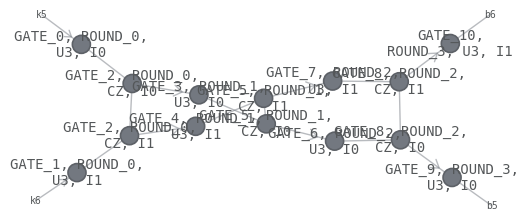

In [57]:
circ.draw()

In [29]:
circ

<Circuit(n=2, num_gates=11, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

In [30]:
V = circ.uni

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


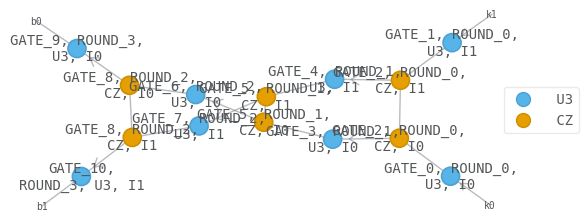

In [32]:
V.draw(color=['U3', gate2], show_inds=True)

In [42]:
help(V.reindex)

Help on method reindex in module quimb.tensor.tensor_core:

reindex(index_map, inplace=False) method of quimb.tensor.tensor_arbgeom.TensorNetworkGenOperator instance
    Rename indices for all tensors in this network, optionally in-place.
    
    Parameters
    ----------
    index_map : dict-like
        Mapping of pairs ``{old_ind: new_ind, ...}``.



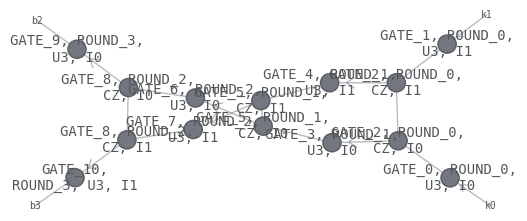

In [43]:
V.reindex({'b0': 'b2', 'b1': 'b3'}).draw()

In [59]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

total_physical_dim = 2**num_boundary_sites

In [62]:
circ_pair = ansatz_circuit_pair(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    depth
)

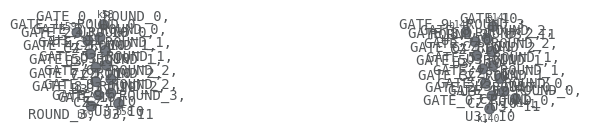

In [63]:
circ_pair.draw()

# Test

In [65]:
k1 = 0
mps_psi = psi_dict[k1]

# Loop and solve for boundary operators

In [33]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

total_physical_dim = 2**num_boundary_sites

In [36]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

In [37]:
k2 = 1
bs = symmetry_actions[1]

In [38]:
symmetry_site_pairs = (
    [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

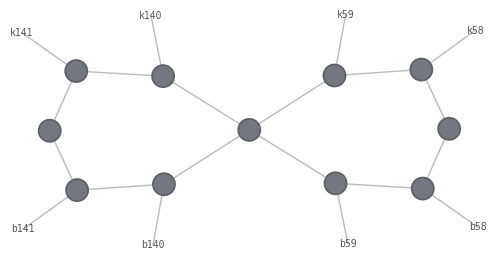

In [39]:
problem_rdm.draw()

In [67]:
(problem_rdm & circ_pair)^...

(-0.025755432585944007-0.025883018396906703j)

In [77]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

In [78]:
loss(circ_pair, problem_rdm)

Array(0.9986667, dtype=float32)

In [79]:
tnopt = qtn.TNOptimizer(
    circ_pair,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

In [80]:
circ_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

  0%|                                                                                                                 | 0/5000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+0.000000178814 [best: -0.000000119209] :  12%|███████▎                                                    | 608/5000 [00:01<00:09, 480.56it/s]


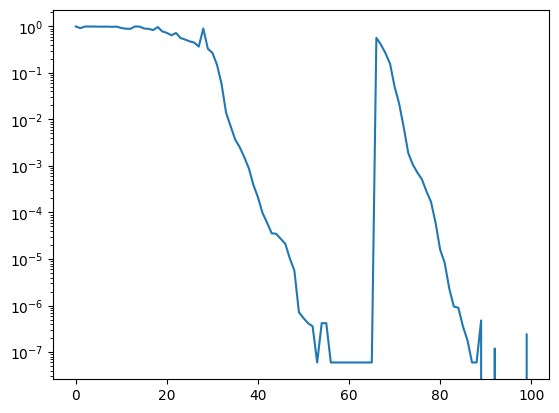

In [87]:
plt.semilogy(tnopt.losses[:100])

In [91]:
tnopt = qtn.TNOptimizer(
    circ_pair,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

In [92]:
circ_opt = tnopt.optimize_basinhopping(
    n=5000,
    nhop=10,
    jac=False,
    hessp=False
)

+0.999271810055 [best: +0.987147450447] :   1%|▋                                                          | 539/50000 [00:01<01:45, 466.81it/s]


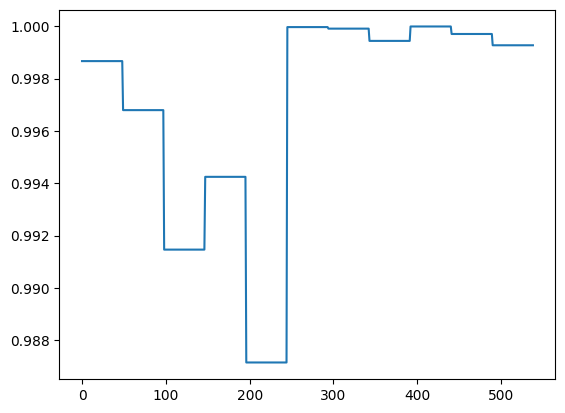

In [95]:
plt.plot(tnopt.losses)

In [96]:
len(tnopt.losses)

539

In [151]:
circ_pair = ansatz_circuit_pair(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    depth
)

tnopt = qtn.TNOptimizer(
    circ_pair,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

circ_opt = tnopt.optimize(
    n=5000,
    jac=False,
    hessp=False,
    tol=1e-3,
    eps=1e-3
)

+0.001595437527 [best: +0.001582920551] :  27%|████████████████▏                                          | 1372/5000 [00:02<00:06, 558.44it/s]


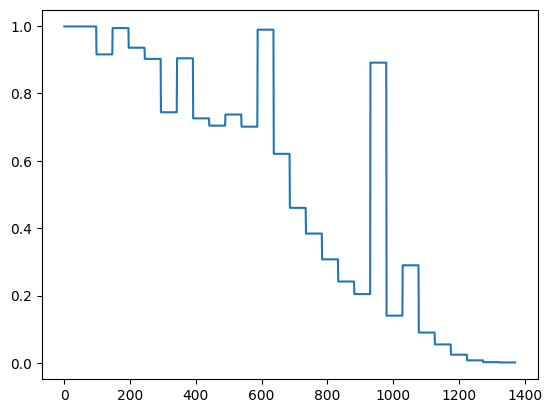

In [152]:
plt.plot(tnopt.losses)

In [153]:
np.min(tnopt.losses)

0.0015829205513000488

# Conclusion
It works!